In [ ]:
import pandas as pd
import time
from nltk.corpus import wordnet
from nltk import pos_tag
import matplotlib.pyplot as plt 
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
import string
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics import classification_report
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def cosine_sim(vec1, vec2):
    dot_prod = 0
    for i, v in enumerate(vec1):
        dot_prod += v * vec2[i]
    mag_1 = math.sqrt(sum([x**2 for x in vec1]))
    mag_2 = math.sqrt(sum([x**2 for x in vec2]))
    return dot_prod / (mag_1 * mag_2)

In [ ]:
def split_train_test(top_data_df_small, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(top_data_df_small[['review', 'stars']], 
                                                        top_data_df_small['stars'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

In [ ]:
def map_stars(stars_received):
    if stars_received  == 5:
        return 5
    elif stars_received >= 4:
        return 4
    elif stars_received >= 3:
        return 3
    elif stars_received >= 2:
        return 2
    else:
        return 1

                                              review  stars
0   I am so angry that i made this post available...   1.45
1  No Negative No real complaints the hotel was g...   3.75
2   Rooms are nice but for elderly a bit difficul...   3.55
3   My room was dirty and I was afraid to walk ba...   1.90
4   You When I booked with your company on line y...   3.35
                                              review  stars
0   I am so angry that i made this post available...   1.45
1   No real complaints the hotel was great great ...   3.75
2   Rooms are nice but for elderly a bit difficul...   3.55
3   My room was dirty and I was afraid to walk ba...   1.90
4   You When I booked with your company on line y...   3.35
Index(['review', 'stars'], dtype='object')
5.00    115853
4.80     71167
4.60     58583
4.40     46429
4.15     41128
3.75     34878
3.95     33097
3.55     24855
3.35     18793
3.15     14924
2.90     12034
2.70      9526
2.50      8422
2.30      6240
2.10      5095
1.90      40

Text(0, 0.5, 'No. of rows in df')

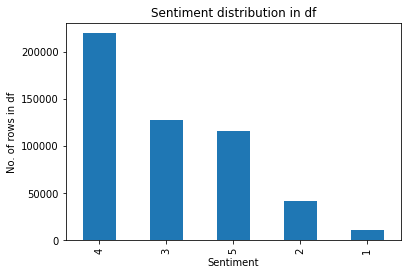

In [ ]:
# read data
reviews_df = pd.read_csv("/content/drive/MyDrive/datasets/Hotel_Reviews.csv")

# append the positive and negative text reviews
reviews_df["review"] = reviews_df["Negative_Review"] + reviews_df["Positive_Review"]
reviews_df["stars"] = reviews_df["Reviewer_Score"].apply(lambda x: x/2)
reviews_df = reviews_df[["review", "stars"]]
print(reviews_df.head())

# remove 'No Negative' or 'No Positive' from text
reviews_df["review"] = reviews_df["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

print(reviews_df.head())
print(reviews_df.columns)
print(reviews_df['stars'].value_counts())
reviews_df['stars'] = [map_stars(x) for x in reviews_df['stars']]    

print(reviews_df['stars'].value_counts())
print(reviews_df.head())
plt.figure()
pd.value_counts(reviews_df['stars']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
# plt.show()

In [ ]:
top_data_df_5star = reviews_df[reviews_df['stars'] == 5].head(10000)
top_data_df_4star = reviews_df[reviews_df['stars'] == 4].head(10000)
top_data_df_3star = reviews_df[reviews_df['stars'] == 3].head(10000)
top_data_df_2star = reviews_df[reviews_df['stars'] == 2].head(10000)
top_data_df_1star = reviews_df[reviews_df['stars'] == 1].head(10000)

top_data_df_small = pd.concat([top_data_df_5star, top_data_df_4star, top_data_df_3star, 
                               top_data_df_2star, top_data_df_1star])


In [ ]:
# After selecting top few samples of each sentiment
print("After segregating and taking equal number of rows for each sentiment:")
print(top_data_df_small['stars'].value_counts())
top_data_df_small.head(10)
X_train, X_test, Y_train, Y_test = split_train_test(top_data_df_small)
top_data_df_small['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in top_data_df_small['review']] 

print(top_data_df_small.head(20))

After segregating and taking equal number of rows for each sentiment:
5    10000
4    10000
3    10000
2    10000
1    10000
Name: stars, dtype: int64
Value counts for Train sentiments
2    7045
3    7023
1    6985
4    6975
5    6972
Name: stars, dtype: int64
Value counts for Test sentiments
5    3028
4    3025
1    3015
3    2977
2    2955
Name: stars, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
    index                                             review  stars
0   70888   This is not a 4 stars hotel Very old furnitur...      2
1   19442   I love the greeting that was always given whe...      5
2  305893   Customer services was very poor attitude was ...      1
3   92431   Very small room if you compared with the valu...      2
4   13267   Room size For a four star hotel the room size...      2
                                                review  stars  \
7     Apart from the price for the brekfast Everyth...      5   
10    Nothing all 

In [ ]:
porter_stemmer = PorterStemmer()
top_data_df_small['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in top_data_df_small['tokenized_text'] ]
print("top_data columns:")
print(top_data_df_small.columns)

top_data columns:
Index(['review', 'stars', 'tokenized_text', 'stemmed_tokens'], dtype='object')


In [ ]:
# TaggedDocuments are tuple of stemmed_tokens and class lable, example is printed (scroll to the right to see label)
documents=[]
for index, row in top_data_df_small.iterrows():
    label=row['stars']
    documents.append(TaggedDocument(row['stemmed_tokens'],[label]))
print(documents[1])

TaggedDocument(['noth', 'all', 'great', 'room', 'were', 'stunningli', 'decor', 'and', 'realli', 'spaciou', 'in', 'the', 'top', 'of', 'the', 'build', 'pictur', 'ar', 'of', 'room', 'the', 'true', 'beauti', 'of', 'the', 'build', 'ha', 'been', 'kept', 'but', 'modernis', 'brilliantli', 'also', 'the', 'bath', 'wa', 'love', 'and', 'big', 'and', 'invit', 'great', 'more', 'for', 'coupl', 'restaur', 'menu', 'wa', 'bit', 'pricei', 'but', 'there', 'were', 'load', 'of', 'littl', 'eateri', 'place', 'nearbi', 'within', 'walk', 'distanc', 'and', 'the', 'tram', 'stop', 'into', 'the', 'centr', 'wa', 'about', 'minut', 'walk', 'awai', 'and', 'onli', 'about', 'or', 'stop', 'from', 'the', 'centr', 'of', 'amsterdam', 'would', 'recommend', 'thi', 'hotel', 'to', 'anyon', 'it', 'unbeliev', 'well', 'price', 'too'], [5])


In [ ]:
# Initialize the model
start_time = time.time()
doc2vec_model = Doc2Vec(documents, vector_size=1000, window=5, min_count=1, workers=4)
five_vector = doc2vec_model.docvecs[5]
five_vector
fourth_vector = doc2vec_model.docvecs[4]
third_vector = doc2vec_model.docvecs[3]
second_vector = doc2vec_model.docvecs[2]
first_vector = doc2vec_model.docvecs[1]
print("Time taken to create doc2vec vectors: " + str(time.time() - start_time))

Time taken to create doc2vec vectors: 59.304503202438354


In [ ]:
X_test['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in X_test['review']] 
X_test['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in X_test['tokenized_text']]

documents2 = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_test['stemmed_tokens'])]
doc2vec_model2 = Doc2Vec(documents2, vector_size=1000, window=7, min_count=1, workers=4, epochs = 20)

In [ ]:
# #Testing the model on the test data
test_features_doc2vec = []
for index, row in X_test.iterrows():
    model_vector = doc2vec_model2.infer_vector(row['stemmed_tokens'])
    test_features_doc2vec.append(model_vector)
# test_predictions_doc2vec = clf_decision_doc2vec.predict(test_features_doc2vec)
# print(classification_report(Y_test['stars'],test_predictions_doc2vec))
X_test.to_csv("file4.csv")

In [ ]:
rating = {5:[],4:[],3:[],2:[],1:[]}
for i in range(100):
#check cosine similarity of test data with the 5 classes doc2vec
    score5 = cosine_sim(test_features_doc2vec[i], five_vector)
    rating[5].append(score5)
    score4 = cosine_sim(test_features_doc2vec[i], fourth_vector)
    rating[4].append(score4)
    score3 = cosine_sim(test_features_doc2vec[i], third_vector)
    rating[3].append(score3)
    score2 = cosine_sim(test_features_doc2vec[i], second_vector)
    rating[2].append(score2)
    score1 = cosine_sim(test_features_doc2vec[i], first_vector)
    rating[1].append(score1)
Y_test.to_csv("file3.csv")
# score = cosine_sim(test_features_doc2vec[1], star_features_doc2vec[5])

In [ ]:
print(rating)

{5: [-0.10896041580948958, 0.00235332111075125, 0.08606250882783104, 0.036710156969223924, 0.0045745851647454785, -0.05607285161921634, -0.11526018158983879, -0.11014141063531344, 0.026761768722223255, 0.0775426010595825, 0.052158860680971, 0.0017859229270587673, 0.07195086008023908, 0.03349094933815058, 0.08913267433355661, 0.030146211309628055, 0.031222889942409456, 0.04985737814323017, 0.06857555678472006, -0.047321322171331885, 0.007701896730058877, 0.027004276929206195, 0.09693785262009764, -0.04444150019161231, -0.1077463721407104, -0.0051551734519473735, -0.10056062102394765, -0.016011436662157867, 0.13625861669071054, 3.7161705947390435e-05, -0.07770005570550842, 0.010454285183841444, 0.04089308994659436, -0.028687930715934815, 0.040910976832965, -0.08233325731278376, 0.06955332342461142, 0.02554066017513755, 0.07255294404049327, -0.029457841940629753, -0.009007744735200792, -0.02250235565056481, 0.007370529349674426, -0.02695808204128606, -0.009577600753971845, -0.022066814590

In [ ]:
cos_matrix = pd.DataFrame.from_dict(rating)

In [ ]:
cos_matrix.head()

,5,4,3,2,1
0,-0.108960,-0.046130,0.084119,0.112201,0.052485
1,0.002353,0.000580,0.069335,0.075199,0.049997
2,0.086063,0.160041,0.191963,0.134956,0.111520
3,0.036710,0.109421,0.165856,0.133407,0.126475
4,0.004575,0.075253,0.166630,0.189353,0.131871


In [ ]:
max_cos = cos_matrix.idxmax(axis=1)

In [ ]:
cos_matrix['pred_rating'] = max_cos
cos_matrix

,5,4,3,2,1,pred_rating
0,-0.108960,-0.046130,0.084119,0.112201,0.052485,2
1,0.002353,0.000580,0.069335,0.075199,0.049997,2
2,0.086063,0.160041,0.191963,0.134956,0.111520,3
3,0.036710,0.109421,0.165856,0.133407,0.126475,3
4,0.004575,0.075253,0.166630,0.189353,0.131871,2
...,...,...,...,...,...,...
95,0.053368,0.102760,0.183169,0.123634,0.108406,3
96,0.027133,0.085682,0.168679,0.163972,0.154952,3
97,0.006298,0.056900,0.167184,0.150678,0.124389,3
98,-0.007705,0.036951,0.128029,0.049787,0.035582,3


In [ ]:
cos_matrix['actual_rating']=Y_test['stars']
cos_matrix

,5,4,3,2,1,pred_rating,actual_rating
0,-0.108960,-0.046130,0.084119,0.112201,0.052485,2,2
1,0.002353,0.000580,0.069335,0.075199,0.049997,2,4
2,0.086063,0.160041,0.191963,0.134956,0.111520,3,4
3,0.036710,0.109421,0.165856,0.133407,0.126475,3,1
4,0.004575,0.075253,0.166630,0.189353,0.131871,2,2
...,...,...,...,...,...,...,...
95,0.053368,0.102760,0.183169,0.123634,0.108406,3,2
96,0.027133,0.085682,0.168679,0.163972,0.154952,3,1
97,0.006298,0.056900,0.167184,0.150678,0.124389,3,2
98,-0.007705,0.036951,0.128029,0.049787,0.035582,3,4


In [ ]:
def compare_results(r):
    if (abs(r['pred_rating']-r['actual_rating']))>=2:
        return 0
    else:
        return 1
cos_matrix['result']=cos_matrix.apply(compare_results, axis=1)
cos_matrix
x = sum(cos_matrix['result'])
print(x)
print(x/len(cos_matrix.index))

66
0.66


In [ ]:
# cos_matrix['abs_error']=abs(cos_matrix['actual_rating']-cos_matrix['pred_rating'])
# print(sum(cos_matrix['abs_error'])/len(cos_matrix.index))

In [ ]:
# print(classification_report(Y_test['stars'].head(10000),cos_matrix['pred_rating']))

In [ ]:
user_input = "This hotel is great if you want to waste your money."
input_tokenized = simple_preprocess(user_input, deacc=True)
print(input_tokenized)
input_stemmed = [porter_stemmer.stem(word) for word in input_tokenized]
print(input_stemmed)
document3 = TaggedDocument(input_stemmed, [0])
doc2vec_model3 = Doc2Vec(documents2, vector_size=1000, window=5, min_count=1, workers=4)

test_vector = doc2vec_model3.infer_vector(input_stemmed)
score5 = cosine_sim(test_vector, five_vector)
score4 = cosine_sim(test_vector, fourth_vector)
score3 = cosine_sim(test_vector, third_vector)
score2 = cosine_sim(test_vector, second_vector)
score1 = cosine_sim(test_vector, first_vector)
print(score1)
print(score2)
print(score3)
print(score4)
print(score5)


['this', 'hotel', 'is', 'great', 'if', 'you', 'want', 'to', 'waste', 'your', 'money']
['thi', 'hotel', 'is', 'great', 'if', 'you', 'want', 'to', 'wast', 'your', 'monei']
0.11683651802944243
0.14506169319405457
0.15296799704473507
0.03600256347672712
-0.045701820339272795
